# Degridder experiment

Here, we're comparing with the Preesm implementation available at https://gitlab.insa-rennes.fr/Anaelle.Cloarec/degridder

First, let's run and measure all scenarios.

In [7]:
import os

experiment_dir = !realpath ~/repos/iara/experiment/degridder
experiment_dir = experiment_dir[0]

grid_size = 5120
num_visibilities = 7848960

class Scenario:
  def __init__(self, name: str, num_cores: int, num_chunks: int, num_supports: int, grid_size: int, num_visibilities: int):
    self.name = name
    self.instance_path = f"{experiment_dir}/instances/{name}"
    self.iara_bin_path = None
    self.preesm_bin_path = None
    self.iara_scheduling_time = None
    self.preesm_scheduling_time = None
    self.srdag_edges = None
    self.srdag_nodes = None
    self.preesm_bin_size = None
    self.iara_bin_size = None
    self.num_cores = num_cores
    self.num_supports = num_supports
    self.num_chunks = num_chunks
    self.num_visibilities = num_visibilities
    self.grid_size = grid_size
    self.dataset_size = "large"

# Generate parametric scenarios

parameters = {
  "NUM_CORES" : [1,2,4,8],
  "NUM_CHUNK" : [1,2,4,8,16,32,64,128,256,512],
  "NUM_KERNEL_SUPPORT" : [8],
}

# parameters = {
#   "NUM_CORES" : [2],
#   "NUM_CHUNK" : [512],
#   "NUM_KERNEL_SUPPORT" : [8],
# }



def shuffle(x: list):
  # let's make sure the corner cases are checked first.
  if len(x) <= 3:
    return x
  m = len(x)//2
  return [x[0]] + [x[-1]] + [x[m]] + shuffle(x[1:m]) + shuffle(x[m+1:-1])

def generate_scenario_file(num_cores: int, num_chunk: int, num_supports: int):
    import os

    scenario_name = f"generated_large_{num_cores}cores_{num_chunk}chunks_{num_supports}supports.scenario"
    template_file = f"{experiment_dir}/templates/parametric_scenario_large_{num_cores}_cores.scenario"
    output_path = os.path.expanduser(f"~/repos/degridder/Scenarios/{scenario_name}")


    # Check if the scenario file already exists
    if os.path.exists(output_path):
        print(f"Scenario {scenario_name} already exists, skipping...")
        return scenario_name

    # Check if template file exists
    if not os.path.exists(template_file):
        print(f"Template file for {num_cores} cores not found: {template_file}")
        return None

    # Read the template file
    with open(template_file, 'r') as f:
        content = f.read()

    # Replace the placeholders
    content = content.replace('«NUM_CHUNK»', str(num_chunk))
    content = content.replace('«NUM_KERNEL_SUPPORT»', str(num_supports))

    # Write the new scenario file
    with open(output_path, 'w') as f:
        f.write(content)

    print(f"Generated scenario: {scenario_name}")
    return scenario_name

def generate_parametric_scenarios():
  global parameters
  global grid_size
  global num_visibilities
  # Let's start from the borders.
  for name, values in parameters.items():
    parameters[name] = shuffle(values)

  print(parameters)

  ! rm ~/repos/degridder/Scenarios/generated*


  ordered_scenarios = []
  names = list(parameters.keys())
  for num_cores in parameters["NUM_CORES"]:
    for num_chunk in parameters["NUM_CHUNK"]:
      for num_supports in parameters["NUM_KERNEL_SUPPORT"]:
        scenario_name = generate_scenario_file(num_cores, num_chunk, num_supports)
        scenario = Scenario(scenario_name, num_cores, num_chunk, num_supports, grid_size, num_visibilities)
        ordered_scenarios.append(scenario)
  return ordered_scenarios

all_ordered_scenarios =  generate_parametric_scenarios()

{'NUM_CORES': [1, 8, 4, 2], 'NUM_CHUNK': [1, 512, 32, 2, 16, 8, 4, 64, 128, 256], 'NUM_KERNEL_SUPPORT': [8]}


Generated scenario: generated_large_1cores_1chunks_8supports.scenario
Generated scenario: generated_large_1cores_512chunks_8supports.scenario
Generated scenario: generated_large_1cores_32chunks_8supports.scenario
Generated scenario: generated_large_1cores_2chunks_8supports.scenario
Generated scenario: generated_large_1cores_16chunks_8supports.scenario
Generated scenario: generated_large_1cores_8chunks_8supports.scenario
Generated scenario: generated_large_1cores_4chunks_8supports.scenario
Generated scenario: generated_large_1cores_64chunks_8supports.scenario
Generated scenario: generated_large_1cores_128chunks_8supports.scenario
Generated scenario: generated_large_1cores_256chunks_8supports.scenario
Generated scenario: generated_large_8cores_1chunks_8supports.scenario
Generated scenario: generated_large_8cores_512chunks_8supports.scenario
Generated scenario: generated_large_8cores_32chunks_8supports.scenario
Generated scenario: generated_large_8cores_2chunks_8supports.scenario
Generate

In [2]:

# take only PXX_ scenarios, sort by number

# all_scenarios = !ls ~/repos/degridder/Scenarios
# all_scenarios = list(filter(lambda x: str(x).startswith("P") and not "complete" in str(x) and not "medium" in str(x), all_scenarios))
# all_scenarios.sort(key=lambda x: int(str(x).split('_')[0].strip('P')))
# all_scenarios

# scenarios : dict[str, Scenario] = {name: Scenario(name) for name in all_scenarios}

# [i.__dict__ for i in scenarios.values()]

In [3]:
# Let's test with just a small one for now.

def small_test():
  global scenarios
  all_scenarios = ["P2_small_32_8_64.scenario"]
  scenarios = {name: Scenario(name) for name in all_scenarios}

# small_test()

In [8]:
# ordered_scenarios = all_ordered_scenarios[10:]
ordered_scenarios = all_ordered_scenarios

In [20]:
# Compile Preesm versions, with a timeout.

def compile_preesm():

  %cd {experiment_dir}
  # !rm -rf instances
  !mkdir -p instances

  for scenario_obj in ordered_scenarios:

    scenario = scenario_obj.name

    !mkdir -p "{experiment_dir}/instances/{scenario}"
    !rm -rf "{experiment_dir}/instances/{scenario}/*"

    command = f"~/repos/preesm-cli/commandLinePreesm.sh ~/Downloads/preesm-3.21.0.202501251928-linux.gtk.x86_64/ ~/repos/degridder/ Codegen.workflow {scenario} >{experiment_dir}/instances/{scenario}/preesm_stdout.txt 2>{experiment_dir}/instances/{scenario}/preesm_stderr.txt"

    print(command)

    ! \time -v -o "{experiment_dir}/instances/{scenario}/preesm_scheduling_time.txt" timeout 3m {command}

    %cd ~/repos/degridder/Code

    !mkdir -p build
    !rm -rf build/*
    !cmake -DCMAKE_BUILD_TYPE=Release --log-level=VERBOSE -B build
    %cd build
    !make

    ! rm -rf "{experiment_dir}/instances/{scenario}/preesm_build"
    ! cp -r ~/repos/degridder/Code/build "{experiment_dir}/instances/{scenario}/preesm_build"

compile_preesm()

/home/jabcross/repos/iara/experiment/degridder


~/repos/preesm-cli/commandLinePreesm.sh ~/Downloads/preesm-3.21.0.202501251928-linux.gtk.x86_64/ ~/repos/degridder/ Codegen.workflow generated_large_8cores_1chunks_8supports.scenario >/home/jabcross/repos/iara/experiment/degridder/instances/generated_large_8cores_1chunks_8supports.scenario/preesm_stdout.txt 2>/home/jabcross/repos/iara/experiment/degridder/instances/generated_large_8cores_1chunks_8supports.scenario/preesm_stderr.txt
/home/jabcross/repos/degridder/Code
/home/jabcross/repos/degridder/Code
-- The C compiler identification is GNU 15.1.1
-- The C compiler identification is GNU 15.1.1
-- The CXX compiler identification is GNU 15.1.1
-- Detecting C compiler ABI info
-- The CXX compiler identification is GNU 15.1.1
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/lib64/ccache/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting C compiler 

In [ ]:
# Compile only scenarios where Preesm failed to produce degridder_pipeline (missing binary)
# Increase timeout to 5 minutes for these cases

for scenario_obj in ordered_scenarios:
  scenario = scenario_obj.name
  preesm_bin_path = f"{experiment_dir}/instances/{scenario}/preesm_build/degridder_pipeline"
  if not os.path.exists(preesm_bin_path):
    print(f"Retrying compilation for scenario: {scenario} with 5m timeout")
    !mkdir -p "{experiment_dir}/instances/{scenario}"
    !rm -rf "{experiment_dir}/instances/{scenario}/*"

    command = f"~/repos/preesm-cli/commandLinePreesm.sh ~/Downloads/preesm-3.21.0.202501251928-linux.gtk.x86_64/ ~/repos/degridder/ Codegen.workflow {scenario} >{experiment_dir}/instances/{scenario}/preesm_stdout.txt 2>{experiment_dir}/instances/{scenario}/preesm_stderr.txt"
    ! \time -v -o "{experiment_dir}/instances/{scenario}/preesm_scheduling_time.txt" timeout 5m {command}

    %cd ~/repos/degridder/Code
    !mkdir -p build
    !rm -rf build/*
    !cmake -DCMAKE_BUILD_TYPE=Release --log-level=VERBOSE -B build
    %cd build
    !make

    ! rm -rf "{experiment_dir}/instances/{scenario}/preesm_build"
    ! cp -r ~/repos/degridder/Code/build "{experiment_dir}/instances/{scenario}/preesm_build"

Retrying compilation for scenario: generated_large_1cores_512chunks_8supports.scenario with 5m timeout
/home/jabcross/repos/degridder/Code
-- The C compiler identification is GNU 15.1.1
-- The CXX compiler identification is GNU 15.1.1
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/lib64/ccache/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/lib64/ccache/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Generate Release project
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD - Success
-- Found Threads: TRUE
-- Found OpenMP_C: -fopenmp (found version "4.5")
-- Found OpenMP_CXX: -fopenmp (found version "4.5")
-- Found OpenMP: TRUE (found version "4.5")
-- Configuring done (0.9s)
-- Generating done (0

Now, let's compile our version.

In [3]:
%cd {experiment_dir}

for scenario in ordered_scenarios:
# for name, scenario in {"P1_small_1_8_1.scenario": scenarios["P1_small_1_8_1.scenario"]}.items():
  scenario.topology_file = f"{experiment_dir}/instances/{scenario.name}/build/topology.mlir"
  scenario.main_file = f"{experiment_dir}/instances/{scenario.name}/build/main.cpp"
  scenario.iara_build_dir = f"{experiment_dir}/instances/{scenario.name}/build"
  ! mkdir -p {scenario.iara_build_dir}
  ! rm -rf {scenario.iara_build_dir}/*
  %cd {scenario.iara_build_dir}
  assert os.getcwd() == scenario.iara_build_dir, f"Not in expected build dir: {os.getcwd()} vs {scenario.iara_build_dir}"
  ! SCHEDULER_MODE=virtual-fifo sh -x ../../../build_instance.sh


/home/jabcross/repos/iara/experiment/degridder


/home/jabcross/repos/iara/experiment/degridder/instances/generated_large_2cores_512chunks_8supports.scenario/build
+++ realpath .
++ basename /home/jabcross/repos/iara/experiment/degridder/instances/generated_large_2cores_512chunks_8supports.scenario/build
+ [[ build -ne build ]]
+ [[ -z virtual-fifo ]]
+ build-iara.sh
-- Using MLIRConfig.cmake in: /home/jabcross/repos/clangir/build/lib/cmake/mlir
-- Using LLVMConfig.cmake in: /home/jabcross/repos/clangir/build/lib/cmake/llvm
CMake Warning at /home/jabcross/repos/clangir/build/lib/cmake/llvm/HandleLLVMOptions.cmake:88 (message):
  Job pooling is only available with Ninja generators.
Call Stack (most recent call first):
  CMakeLists.txt:33 (include)


-- Building with -fPIC
-- Using MLIRConfig.cmake in: /home/jabcross/repos/clangir/build/lib/cmake/mlir
-- Using LLVMConfig.cmake in: /home/jabcross/repos/clangir/build/lib/cmake/llvm
CMake Warning at /home/jabcross/repos/clangir/build/lib/cmake/llvm/HandleLLVMOptions.cmake:88 (message):
  

In [4]:
# Let's run them now.

for scenario in ordered_scenarios:
  %cd {scenario.instance_path}/build
  ! NUM_CORES={scenario.num_cores} sh -x ../../../run_instance.sh


/home/jabcross/repos/iara/experiment/degridder/instances/generated_large_2cores_512chunks_8supports.scenario/build
+ pwd
/home/jabcross/repos/iara/experiment/degridder/instances/generated_large_2cores_512chunks_8supports.scenario/build
+++ realpath .
++ basename /home/jabcross/repos/iara/experiment/degridder/instances/generated_large_2cores_512chunks_8supports.scenario/build
+ [[ build -ne build ]]
+ [[ -z 2 ]]
+ [[ 2 == 1 ]]
+ [[ 2 == 2 ]]
+ CPU_MASK=0,1
+ [[ ! -f degridder_pipeline ]]
+ cd ../
+ rm -f data
+ rm -f output
+ ln -s ../../Code/data .
+ ln -s ../../Code/output .
+ cd preesm_build
+ OMP_NUM_THREADS=2
+ OMP_PROC_BIND=true
+ OMP_PLACES=cores
+ /usr/bin/time -v -o ../preesm_degridder_time.txt taskset -c 0,1 ./degridder_pipeline
+ cd ../build
+ OMP_NUM_THREADS=2
+ OMP_PROC_BIND=true
+ OMP_PLACES=cores
+ /usr/bin/time -v -o ../iara_degridder_time.txt taskset -c 0,1 ./degridder_pipeline


In [9]:
# get data from preesm compilation sizes

import os
import re

for scenario in all_ordered_scenarios:
  scenario.preesm_bin_path = f'{experiment_dir}/instances/{scenario.name}/preesm_build/degridder_pipeline'
  if os.path.exists(scenario.preesm_bin_path):
    scenario.preesm_bin_size = os.path.getsize(scenario.preesm_bin_path)
    walltime_str = ! grep "wall clock" '{experiment_dir}/instances/{scenario.name}/preesm_scheduling_time.txt' | cut -f 8 -d ' '
    time_str = walltime_str[0].strip()
    minutes, seconds = time_str.split(':')
    scenario.preesm_scheduling_time = float(minutes) * 60 + float(seconds)

  srdag_output = ! grep "SRDAG" {experiment_dir}/instances/{scenario.name}/preesm_stdout.txt
  if srdag_output and len(srdag_output) > 0:
    match = re.search(r'SRDAG with (\d+) vertices and (\d+) edges', srdag_output[0])
    if match:
      scenario.srdag_nodes = int(match.group(1))
      scenario.srdag_edges = int(match.group(2))
    else:
      scenario.srdag_nodes = None
      scenario.srdag_edges = None

!ls -lah {experiment_dir}/instances/*/preesm_build/degridder_pipeline

[(s.name, s.preesm_bin_size, s.srdag_nodes, s.srdag_edges) for s in ordered_scenarios]

-rwxr-xr-x. 1 jabcross jabcross 1.8M Aug 20 16:26 /home/jabcross/repos/iara/experiment/degridder/instances/generated_large_1cores_128chunks_8supports.scenario/preesm_build/degridder_pipeline
-rwxr-xr-x. 1 jabcross jabcross 1.5M Aug 20 16:25 /home/jabcross/repos/iara/experiment/degridder/instances/generated_large_1cores_16chunks_8supports.scenario/preesm_build/degridder_pipeline
-rwxr-xr-x. 1 jabcross jabcross 1.5M Aug 20 16:22 /home/jabcross/repos/iara/experiment/degridder/instances/generated_large_1cores_1chunks_8supports.scenario/preesm_build/degridder_pipeline
-rwxr-xr-x. 1 jabcross jabcross 2.2M Aug 20 16:28 /home/jabcross/repos/iara/experiment/degridder/instances/generated_large_1cores_256chunks_8supports.scenario/preesm_build/degridder_pipeline
-rwxr-xr-x. 1 jabcross jabcross 1.5M Aug 20 16:25 /home/jabcross/repos/iara/experiment/degridder/instances/generated_large_1cores_2chunks_8supports.scenario/preesm_build/degridder_pipeline
-rwxr-xr-x. 1 jabcross jabcross 1.6M Aug 20 16:25 

[('generated_large_1cores_1chunks_8supports.scenario', 1509128, 12, 17),
 ('generated_large_1cores_512chunks_8supports.scenario', None, 530, 3601),
 ('generated_large_1cores_32chunks_8supports.scenario', 1594240, 50, 241),
 ('generated_large_1cores_2chunks_8supports.scenario', 1513736, 20, 31),
 ('generated_large_1cores_16chunks_8supports.scenario', 1553616, 34, 129),
 ('generated_large_1cores_8chunks_8supports.scenario', 1527256, 26, 73),
 ('generated_large_1cores_4chunks_8supports.scenario', 1518264, 22, 45),
 ('generated_large_1cores_64chunks_8supports.scenario', 1679864, 82, 465),
 ('generated_large_1cores_128chunks_8supports.scenario', 1857632, 146, 913),
 ('generated_large_1cores_256chunks_8supports.scenario', 2207432, 274, 1809),
 ('generated_large_8cores_1chunks_8supports.scenario', 1526280, 12, 17),
 ('generated_large_8cores_512chunks_8supports.scenario', None, 530, 3601),
 ('generated_large_8cores_32chunks_8supports.scenario', 1646608, 50, 241),
 ('generated_large_8cores_2chu

In [10]:
# get iara binary data

for scenario in all_ordered_scenarios:
  scenario.iara_bin_path = f'{experiment_dir}/instances/{scenario.name}/build/degridder_pipeline'
  if os.path.exists(scenario.iara_bin_path):
    scenario.iara_bin_size = os.path.getsize(scenario.iara_bin_path)
    walltime_str = ! grep "wall clock" '{experiment_dir}/instances/{scenario.name}/iara_scheduling_time.txt' | cut -f 8 -d ' '
    time_str = walltime_str[0].strip()
    minutes, seconds = time_str.split(':')
    scenario.iara_scheduling_time = float(minutes) * 60 + float(seconds)


!ls -lah {experiment_dir}/instances/*/build/degridder_pipeline

[(s.name, s.iara_bin_size, s.iara_scheduling_time) for s in ordered_scenarios]

-rwxr-xr-x. 1 jabcross jabcross 372K Aug 20 16:31 /home/jabcross/repos/iara/experiment/degridder/instances/generated_large_1cores_128chunks_8supports.scenario/build/degridder_pipeline
-rwxr-xr-x. 1 jabcross jabcross 360K Aug 20 16:30 /home/jabcross/repos/iara/experiment/degridder/instances/generated_large_1cores_16chunks_8supports.scenario/build/degridder_pipeline
-rwxr-xr-x. 1 jabcross jabcross 360K Aug 20 16:29 /home/jabcross/repos/iara/experiment/degridder/instances/generated_large_1cores_1chunks_8supports.scenario/build/degridder_pipeline
-rwxr-xr-x. 1 jabcross jabcross 360K Aug 20 16:31 /home/jabcross/repos/iara/experiment/degridder/instances/generated_large_1cores_256chunks_8supports.scenario/build/degridder_pipeline
-rwxr-xr-x. 1 jabcross jabcross 360K Aug 20 16:29 /home/jabcross/repos/iara/experiment/degridder/instances/generated_large_1cores_2chunks_8supports.scenario/build/degridder_pipeline
-rwxr-xr-x. 1 jabcross jabcross 364K Aug 20 16:29 /home/jabcross/repos/iara/experimen

[('generated_large_1cores_1chunks_8supports.scenario', 368160, 0.55),
 ('generated_large_1cores_512chunks_8supports.scenario', 368208, 0.97),
 ('generated_large_1cores_32chunks_8supports.scenario', 372360, 0.97),
 ('generated_large_1cores_2chunks_8supports.scenario', 368200, 0.78),
 ('generated_large_1cores_16chunks_8supports.scenario', 368232, 1.35),
 ('generated_large_1cores_8chunks_8supports.scenario', 368208, 1.3),
 ('generated_large_1cores_4chunks_8supports.scenario', 368200, 1.0),
 ('generated_large_1cores_64chunks_8supports.scenario', 372432, 1.4),
 ('generated_large_1cores_128chunks_8supports.scenario', 380496, 1.07),
 ('generated_large_1cores_256chunks_8supports.scenario', 368208, 1.17),
 ('generated_large_8cores_1chunks_8supports.scenario', 368160, 0.26),
 ('generated_large_8cores_512chunks_8supports.scenario', 368208, 0.75),
 ('generated_large_8cores_32chunks_8supports.scenario', 372360, 1.1),
 ('generated_large_8cores_2chunks_8supports.scenario', 368200, 0.84),
 ('generated

In [11]:
# Helper functions for plotting to reduce code repetition

from typing import List, Optional, Union
import matplotlib.axes
import numpy as np


def add_timeout_labels(ax: matplotlib.axes.Axes, x_positions: np.ndarray, values: List[Optional[float]], bar_width_offset: float = 0) -> float:
    """Add 'Timeout' labels for None values in the data and return their height in graph units"""
    timeout_height_in_graph_units = 0

    for idx, val in enumerate(values):
        if val is None:
            # Add the timeout label
            text_obj = ax.text(x_positions[idx] + bar_width_offset, 0.5, 'Timeout',
                               ha='center', va='bottom', color='red', rotation=90)

            # Calculate the height of the rotated text in graph units
            # For a 90-degree rotated text, the height becomes the width in graph coordinates
            renderer = ax.figure.canvas.get_renderer()
            bbox = text_obj.get_window_extent(renderer=renderer)

            # Transform from display coordinates to data coordinates
            bbox_data = bbox.transformed(ax.transData.inverted())

            # For rotated text (90 degrees), width in display becomes height in graph
            text_width_in_data = bbox_data.height
            # This is the "height" of rotated text
            text_height_in_graph = text_width_in_data

            timeout_height_in_graph_units = max(
                timeout_height_in_graph_units, text_height_in_graph + 0.5)

    return timeout_height_in_graph_units


def add_edge_count_labels(ax: matplotlib.axes.Axes, x_positions: np.ndarray, values: List[Optional[float]],
                          srdag_edges: List[Optional[int]], offset_percentage: float = 0.05,
                          timeout_height: float = 0) -> None:
    """Add edge count labels above bars, with offset relative to graph scale"""
    # Calculate offset based on the current y-axis range
    y_min, y_max = ax.get_ylim()
    graph_scale_offset = (y_max - y_min) * offset_percentage

    for idx, edge_count in enumerate(srdag_edges):
        if edge_count is not None:
            max_height = values[idx] if values[idx] is not None else 0
            max_height = max(max_height, (timeout_height *1.1) if values[idx] is None else 0)

            y_position = max_height + graph_scale_offset

            ax.text(x_positions[idx], y_position,
                    f"#edges:\n{edge_count}",
                    ha='center', va='bottom', fontsize=8, color='black')


def setup_bar_plot(ax: matplotlib.axes.Axes, x_positions: np.ndarray, values: List[Optional[float]],
                   bar_width: float, color_map: List[str],
                   ylabel: str, xlabel: str, title: str, scenario_names: List[str]) -> matplotlib.container.BarContainer:
    """Setup a basic bar plot with common formatting"""
    bars = ax.bar(x_positions, [v if v is not None else 0 for v in values],
                  bar_width, color=color_map)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(scenario_names, rotation=90)
    return bars


def set_ylim_with_padding(ax: matplotlib.axes.Axes, values: List[Optional[float]],
                          padding_factor: float = 1.2, min_timeout_space: float = 20.0) -> None:
    """Set y-axis limits with padding to accommodate labels and timeout scenarios"""
    max_val = max([v for v in values if v is not None], default=0)
    if max_val > 0:
        ax.set_ylim(0, max_val * padding_factor)
    else:
        # If all values are None (timeouts), ensure enough space for labels
        ax.set_ylim(0, min_timeout_space)

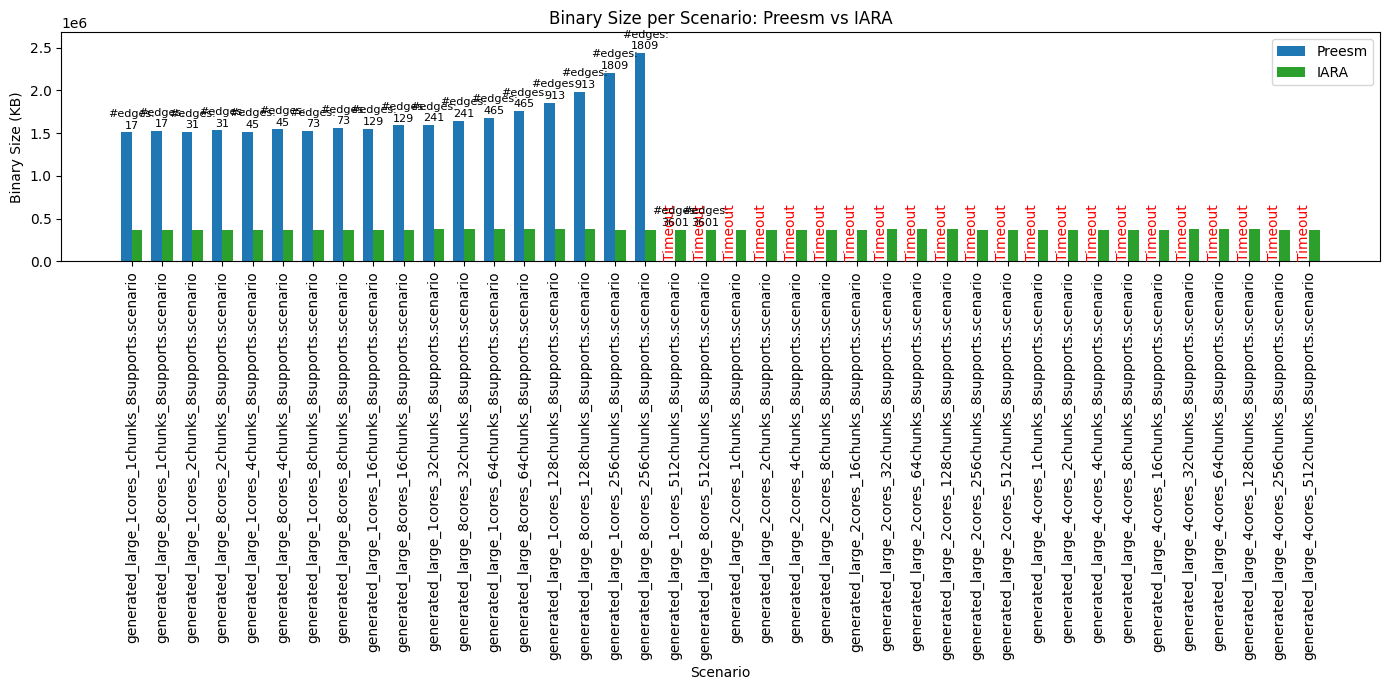

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Map scenario name to Preesm binary path
preesm_binary_map = {}
iara_binary_map = {}

# Collect sizes for both Preesm and IARA
preesm_sizes = []
iara_sizes = []

scenario_list : list[Scenario] = list(all_ordered_scenarios)

scenario_list.sort(key = lambda s: (s.srdag_edges if s.srdag_edges else 9999999999, s.num_cores, s.num_chunks, s.num_supports))

scenario_names = [s.name for s in scenario_list]
preesm_sizes = [s.preesm_bin_size for s in scenario_list]
iara_sizes = [s.iara_bin_size for s in scenario_list]
srdag_edges = [s.srdag_edges for s in scenario_list]

x = np.arange(len(scenario_names))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 7))

# Create color maps for the bars
preesm_colors = ['tab:blue' if s is not None else 'tab:red' for s in preesm_sizes]
iara_colors = ['tab:green' if s is not None else 'tab:red' for s in iara_sizes]

# Plot bars
bars1 = ax.bar(x - width/2, [s if s is not None else 0 for s in preesm_sizes], 
              width, label='Preesm', color=preesm_colors)
bars2 = ax.bar(x + width/2, [s if s is not None else 0 for s in iara_sizes], 
              width, label='IARA', color=iara_colors)

ax.set_ylabel('Binary Size (KB)')
ax.set_xlabel('Scenario')
ax.set_title('Binary Size per Scenario: Preesm vs IARA')
ax.set_xticks(x)
ax.set_xticklabels(scenario_names, rotation=90)
ax.legend()

# Add timeout labels
add_timeout_labels(ax, x, preesm_sizes, -width/2)
add_timeout_labels(ax, x, iara_sizes, width/2)

# Add edge count labels
for idx, edge_count in enumerate(srdag_edges):
  if edge_count is not None:
    max_height = max(
      (preesm_sizes[idx] if preesm_sizes[idx] is not None else 0),
      (iara_sizes[idx] if iara_sizes[idx] is not None else 0)
    )
    ax.text(x[idx], max_height + 20000, f"#edges:\n{edge_count}", 
           ha='center', va='bottom', fontsize=8, color='black')

# Set y-axis limits
ymax = max(
  [s for s in preesm_sizes if s is not None] + 
  [s for s in iara_sizes if s is not None]
)
ax.set_ylim(0, ymax * 1.1)

plt.tight_layout()
plt.show()

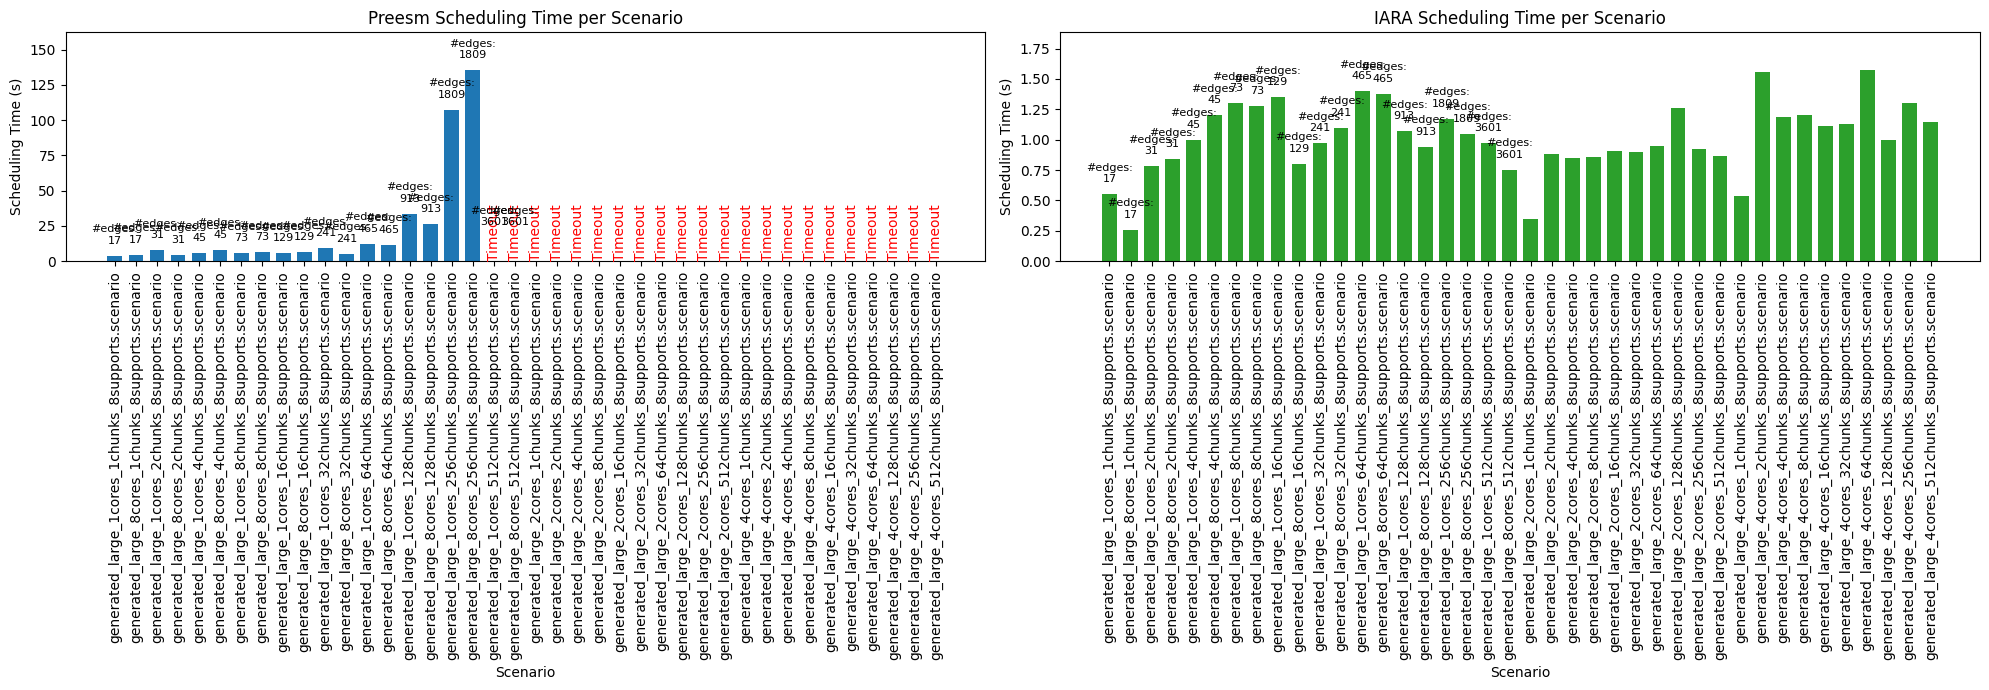

In [14]:
# Prepare scheduling times for Preesm and IARA
preesm_times = [s.preesm_scheduling_time for s in scenario_list]
iara_times = [s.iara_scheduling_time for s in scenario_list]

# Create two side-by-side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# Create color maps
preesm_colors = ['tab:blue' if t is not None else 'tab:red' for t in preesm_times]
iara_colors = ['tab:green' if t is not None else 'tab:red' for t in iara_times]

# Plot Preesm times
setup_bar_plot(ax1, x, preesm_times, width*2, preesm_colors,
               'Scheduling Time (s)', 'Scenario', 'Preesm Scheduling Time per Scenario', 
               scenario_names)

timeout_height = add_timeout_labels(ax1, x, preesm_times)
add_edge_count_labels(ax1, x, preesm_times, srdag_edges, timeout_height=timeout_height)
set_ylim_with_padding(ax1, preesm_times, 1.2)

# Plot IARA times
setup_bar_plot(ax2, x, iara_times, width*2, iara_colors,
               'Scheduling Time (s)', 'Scenario', 'IARA Scheduling Time per Scenario', 
               scenario_names)

add_timeout_labels(ax2, x, iara_times)
add_edge_count_labels(ax2, x, iara_times, srdag_edges, timeout_height=0)
set_ylim_with_padding(ax2, iara_times, 1.2)

plt.tight_layout()
plt.show()

In [15]:
# Extract execution performance data from time files
import re

def parse_time_file(file_path):
    """Parse /usr/bin/time -v output to extract wall time and max RSS"""
    try:
        with open(file_path, 'r') as f:
            content = f.read()
        
        # Extract wall clock time (format: h:mm:ss or mm:ss.ss)
        wall_time_match = re.search(r'Elapsed \(wall clock\) time \(h:mm:ss or m:ss\): (.+)', content)
        wall_time_seconds = None
        if wall_time_match:
            time_str = wall_time_match.group(1).strip()
            if ':' in time_str:
                parts = time_str.split(':')
                if len(parts) == 3:  # h:mm:ss
                    hours, minutes, seconds = parts
                    wall_time_seconds = float(hours) * 3600 + float(minutes) * 60 + float(seconds)
                elif len(parts) == 2:  # mm:ss
                    minutes, seconds = parts
                    wall_time_seconds = float(minutes) * 60 + float(seconds)
            else:
                wall_time_seconds = float(time_str)
        
        # Extract maximum resident set size (in KB)
        max_rss_match = re.search(r'Maximum resident set size \(kbytes\): (\d+)', content)
        max_rss_kb = int(max_rss_match.group(1)) if max_rss_match else None
        
        return wall_time_seconds, max_rss_kb
    except FileNotFoundError:
        return None, None
    except Exception as e:
        print(f"Error parsing {file_path}: {e}")
        return None, None

# Extract execution data for all scenarios
for scenario in scenario_list:
    # Parse Preesm execution data
    preesm_time_file = f'{experiment_dir}/instances/{scenario.name}/preesm_degridder_time.txt'
    scenario.preesm_wall_time, scenario.preesm_max_rss = parse_time_file(preesm_time_file)
    
    # Parse IARA execution data
    iara_time_file = f'{experiment_dir}/instances/{scenario.name}/iara_degridder_time.txt'
    scenario.iara_wall_time, scenario.iara_max_rss = parse_time_file(iara_time_file)

# Display summary of extracted data
print("Execution Performance Data Summary:")
print("Scenario | Preesm Wall Time (s) | IARA Wall Time (s) | Preesm Max RSS (KB) | IARA Max RSS (KB)")
print("-" * 90)
for scenario in scenario_list:
    preesm_wt = f"{scenario.preesm_wall_time:.2f}" if scenario.preesm_wall_time else "N/A"
    iara_wt = f"{scenario.iara_wall_time:.2f}" if scenario.iara_wall_time else "N/A"
    preesm_rss = str(scenario.preesm_max_rss) if scenario.preesm_max_rss else "N/A"
    iara_rss = str(scenario.iara_max_rss) if scenario.iara_max_rss else "N/A"
    print(f"{scenario.name[:20]:<20} | {preesm_wt:>17} | {iara_wt:>15} | {preesm_rss:>16} | {iara_rss:>14}")

Execution Performance Data Summary:
Scenario | Preesm Wall Time (s) | IARA Wall Time (s) | Preesm Max RSS (KB) | IARA Max RSS (KB)
------------------------------------------------------------------------------------------
generated_large_1cor |             20.98 |           19.74 |          1177424 |        1178788
generated_large_8cor |             27.21 |           40.38 |          1127740 |        1180560
generated_large_1cor |             17.55 |           18.17 |          1183276 |        1178732
generated_large_8cor |             42.78 |           42.71 |          1182536 |        1110536
generated_large_1cor |             19.62 |           18.18 |          1624912 |        1419924
generated_large_8cor |             42.95 |           39.27 |          1624832 |        1532844
generated_large_1cor |             20.80 |           20.83 |          2822932 |        2617956
generated_large_8cor |             39.23 |           56.17 |          2823100 |        2731296
generated_large_1c

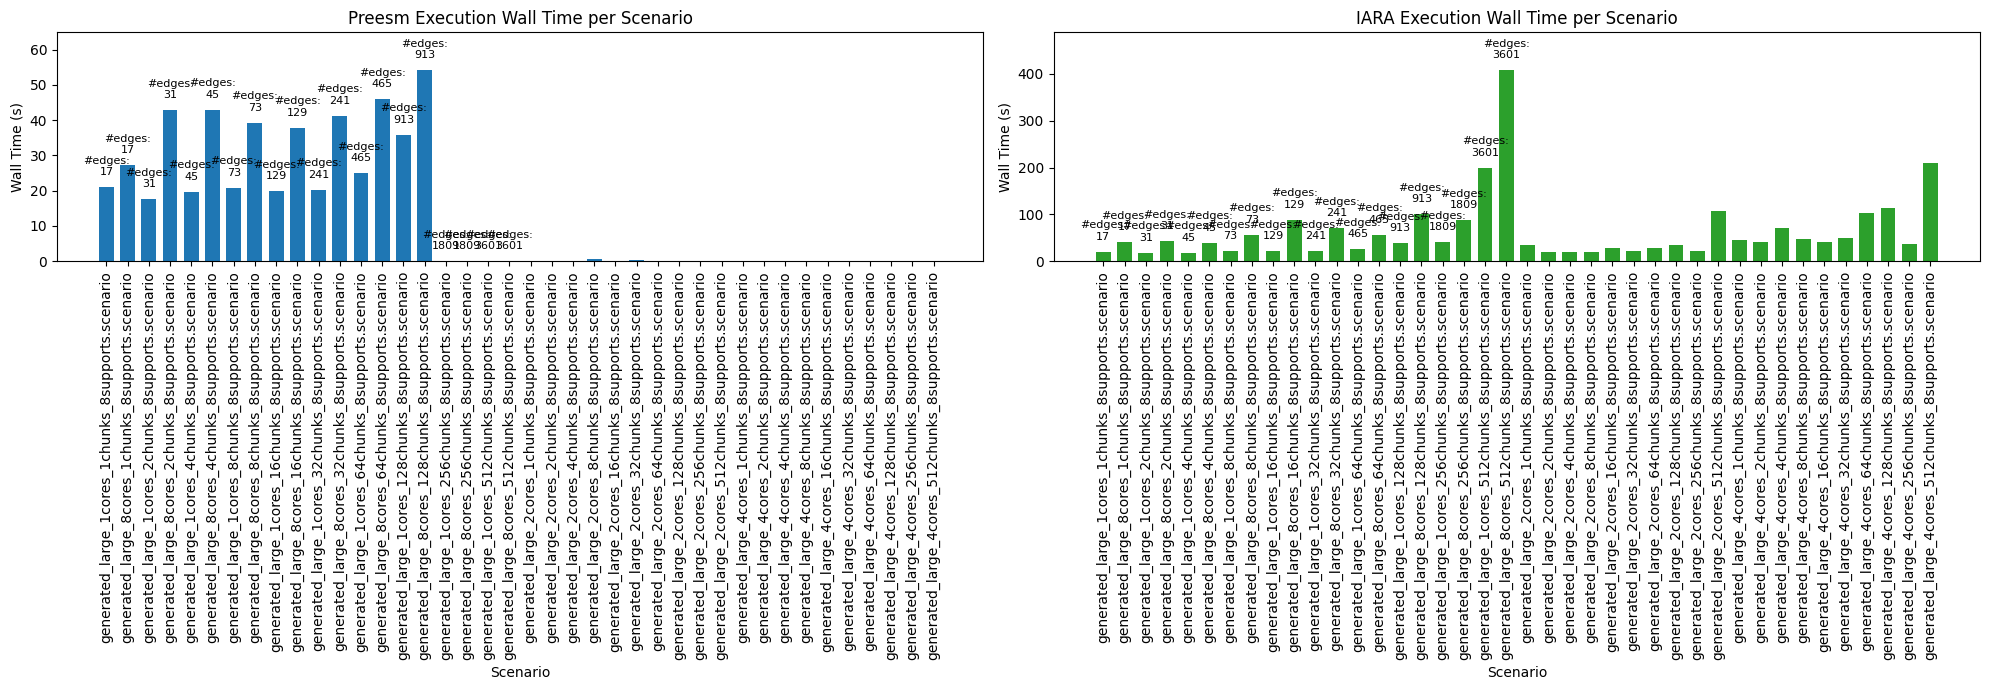

In [16]:
# Create wall time comparison graphs
preesm_wall_times = [s.preesm_wall_time for s in scenario_list]
iara_wall_times = [s.iara_wall_time for s in scenario_list]

# Create two side-by-side subplots for wall time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# Create color maps
preesm_colors = ['tab:blue' if t is not None else 'tab:red' for t in preesm_wall_times]
iara_colors = ['tab:green' if t is not None else 'tab:red' for t in iara_wall_times]

# Plot Preesm wall times
setup_bar_plot(ax1, x, preesm_wall_times, width*2, preesm_colors,
               'Wall Time (s)', 'Scenario', 'Preesm Execution Wall Time per Scenario', 
               scenario_names)

timeout_height = add_timeout_labels(ax1, x, preesm_wall_times)
add_edge_count_labels(ax1, x, preesm_wall_times, srdag_edges, timeout_height=timeout_height)
set_ylim_with_padding(ax1, preesm_wall_times, 1.2)

# Plot IARA wall times
setup_bar_plot(ax2, x, iara_wall_times, width*2, iara_colors,
               'Wall Time (s)', 'Scenario', 'IARA Execution Wall Time per Scenario', 
               scenario_names)

add_timeout_labels(ax2, x, iara_wall_times)
add_edge_count_labels(ax2, x, iara_wall_times, srdag_edges, timeout_height=0)
set_ylim_with_padding(ax2, iara_wall_times, 1.2)

plt.tight_layout()
plt.show()

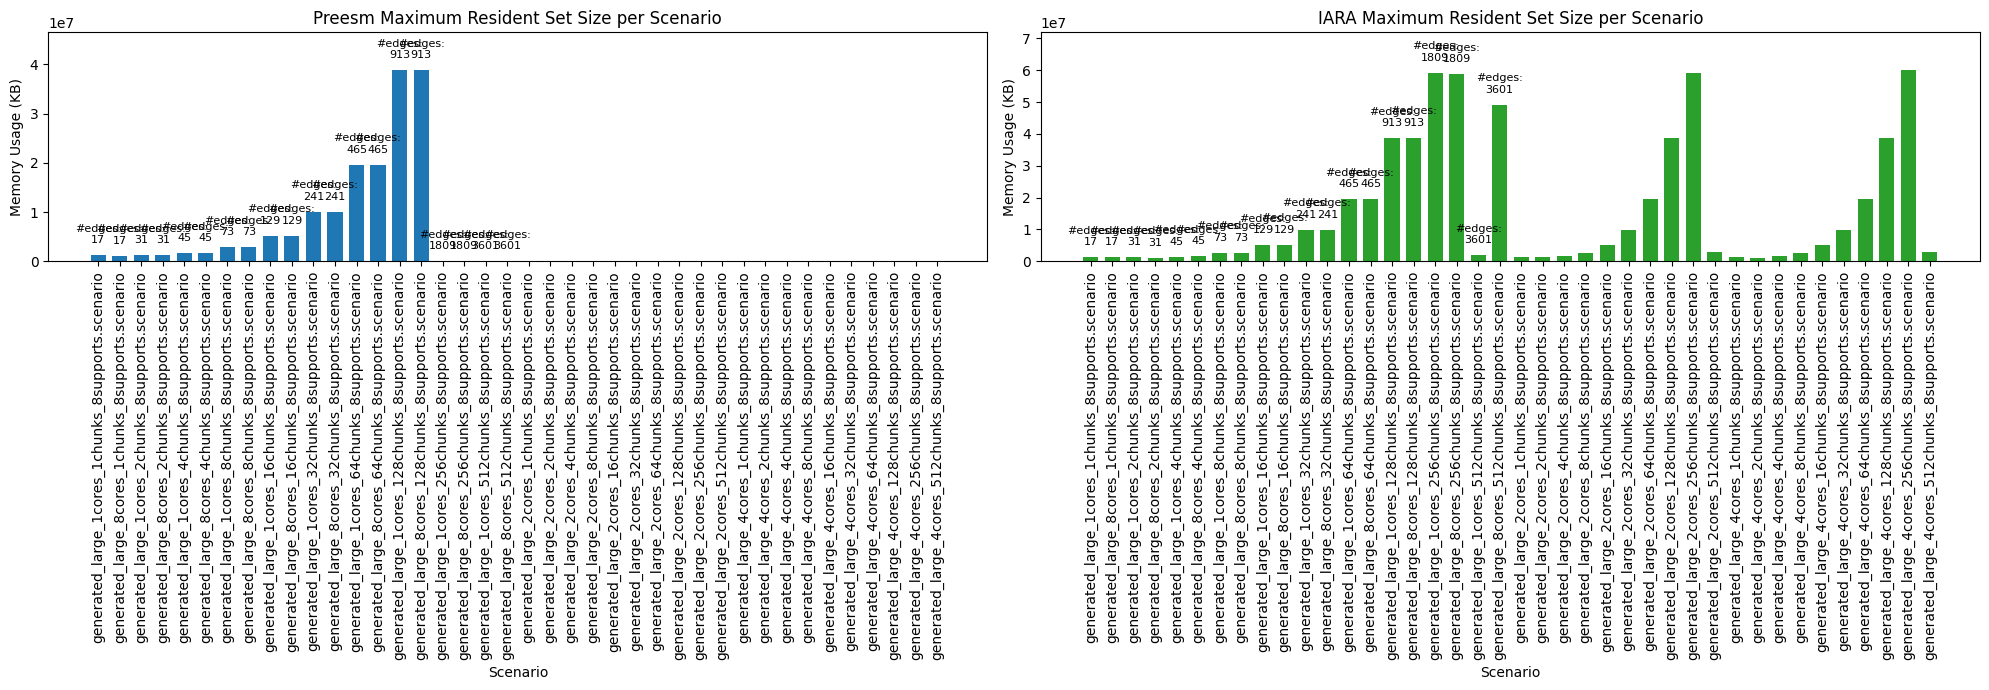

In [ ]:
# Create maximum resident set size comparison graphs
preesm_max_rss = [s.preesm_max_rss for s in scenario_list]
iara_max_rss = [s.iara_max_rss for s in scenario_list]

# Create two side-by-side subplots for memory usage
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# Create color maps
preesm_colors = ['tab:blue' if rss is not None else 'tab:red' for rss in preesm_max_rss]
iara_colors = ['tab:green' if rss is not None else 'tab:red' for rss in iara_max_rss]

# Plot Preesm memory usage
setup_bar_plot(ax1, x, preesm_max_rss, width*2, preesm_colors,
               'Memory Usage (KB)', 'Scenario', 'Preesm Maximum Resident Set Size per Scenario', 
               scenario_names)

timeout_height = add_timeout_labels(ax1, x, preesm_max_rss)
add_edge_count_labels(ax1, x, preesm_max_rss, srdag_edges, timeout_height=timeout_height)
set_ylim_with_padding(ax1, preesm_max_rss, 1.2)

# Plot IARA memory usage
setup_bar_plot(ax2, x, iara_max_rss, width*2, iara_colors,
               'Memory Usage (KB)', 'Scenario', 'IARA Maximum Resident Set Size per Scenario', 
               scenario_names)

add_timeout_labels(ax2, x, iara_max_rss)
add_edge_count_labels(ax2, x, iara_max_rss, srdag_edges, timeout_height=0)
set_ylim_with_padding(ax2, iara_max_rss, 1.2)

plt.tight_layout()
plt.show()

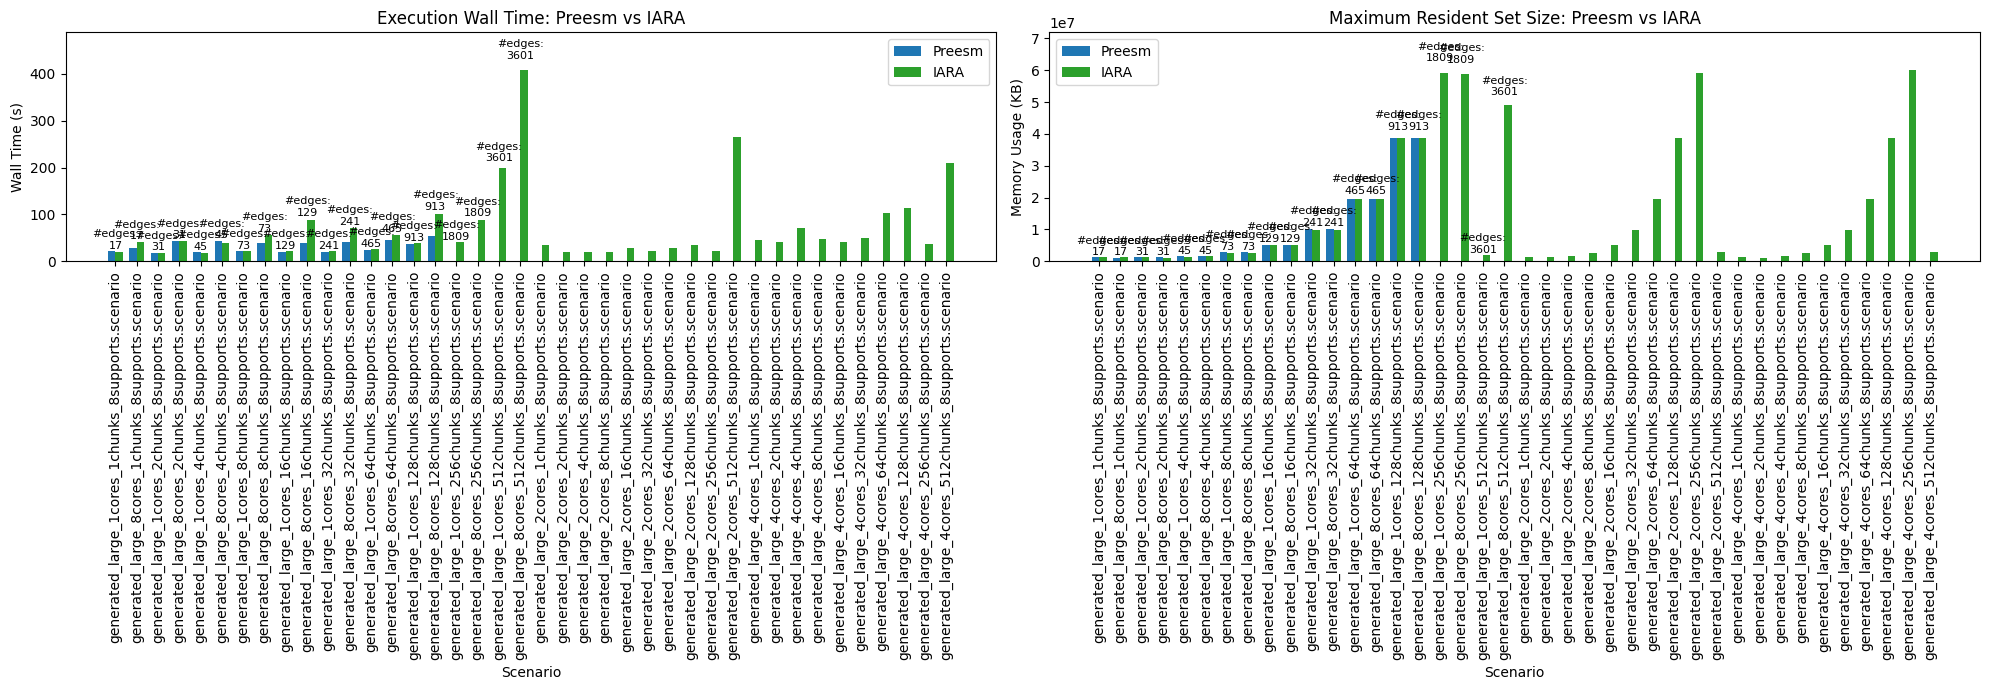

In [ ]:
# Create combined performance comparison graphs (side-by-side bars)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# Wall Time Comparison (side-by-side bars)
preesm_wall_colors = ['tab:blue' if t is not None else 'tab:red' for t in preesm_wall_times]
iara_wall_colors = ['tab:green' if t is not None else 'tab:red' for t in iara_wall_times]

bars1 = ax1.bar(x - width/2, [t if t is not None else 0 for t in preesm_wall_times], 
              width, label='Preesm', color=preesm_wall_colors)
bars2 = ax1.bar(x + width/2, [t if t is not None else 0 for t in iara_wall_times], 
              width, label='IARA', color=iara_wall_colors)

ax1.set_ylabel('Wall Time (s)')
ax1.set_xlabel('Scenario')
ax1.set_title('Execution Wall Time: Preesm vs IARA')
ax1.set_xticks(x)
ax1.set_xticklabels(scenario_names, rotation=90)
ax1.legend()

# Add timeout labels for wall time
add_timeout_labels(ax1, x, preesm_wall_times, -width/2)
add_timeout_labels(ax1, x, iara_wall_times, width/2)

# Add edge count labels for wall time
for idx, edge_count in enumerate(srdag_edges):
    if edge_count is not None:
        max_height = max(
            (preesm_wall_times[idx] if preesm_wall_times[idx] is not None else 0),
            (iara_wall_times[idx] if iara_wall_times[idx] is not None else 0)
        )
        if max_height > 0:
            ax1.text(x[idx], max_height * 1.05, f"#edges:\n{edge_count}", 
                   ha='center', va='bottom', fontsize=8, color='black')

# Memory Usage Comparison (side-by-side bars)
preesm_rss_colors = ['tab:blue' if rss is not None else 'tab:red' for rss in preesm_max_rss]
iara_rss_colors = ['tab:green' if rss is not None else 'tab:red' for rss in iara_max_rss]

bars3 = ax2.bar(x - width/2, [rss if rss is not None else 0 for rss in preesm_max_rss], 
              width, label='Preesm', color=preesm_rss_colors)
bars4 = ax2.bar(x + width/2, [rss if rss is not None else 0 for rss in iara_max_rss], 
              width, label='IARA', color=iara_rss_colors)

ax2.set_ylabel('Memory Usage (KB)')
ax2.set_xlabel('Scenario')
ax2.set_title('Maximum Resident Set Size: Preesm vs IARA')
ax2.set_xticks(x)
ax2.set_xticklabels(scenario_names, rotation=90)
ax2.legend()

# Add timeout labels for memory usage
add_timeout_labels(ax2, x, preesm_max_rss, -width/2)
add_timeout_labels(ax2, x, iara_max_rss, width/2)

# Add edge count labels for memory usage
for idx, edge_count in enumerate(srdag_edges):
    if edge_count is not None:
        max_height = max(
            (preesm_max_rss[idx] if preesm_max_rss[idx] is not None else 0),
            (iara_max_rss[idx] if iara_max_rss[idx] is not None else 0)
        )
        if max_height > 0:
            ax2.text(x[idx], max_height * 1.05, f"#edges:\n{edge_count}", 
                   ha='center', va='bottom', fontsize=8, color='black')

# Set y-axis limits
wall_time_max = max(
    [t for t in preesm_wall_times if t is not None] + 
    [t for t in iara_wall_times if t is not None],
    default=0
)
if wall_time_max > 0:
    ax1.set_ylim(0, wall_time_max * 1.2)

rss_max = max(
    [rss for rss in preesm_max_rss if rss is not None] + 
    [rss for rss in iara_max_rss if rss is not None],
    default=0
)
if rss_max > 0:
    ax2.set_ylim(0, rss_max * 1.2)

plt.tight_layout()
plt.show()